In [65]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL.Image as Image
from dataclasses import dataclass
import torch 
import cv2
import PIL
from glob import glob
from os import listdir
from os.path import isfile, join
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

import tensorflow as tf

## Data Files 

**· img_align_celeba.zip：** All the face images, cropped and aligned 

**· list_attr_celeba.csv:** Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative  

**· list_eval_partition.csv:** Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing

**· list_bbox_celeba.csv:** Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box

**· list_landmarks_align_celeba.csv:** Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth

In [ ]:
!pwd

/nfs/home/ikq2724/deep_learning/project


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yaasirahmed","key":"900002160fb89eb3f9c3e4f3236b643b"}'}

In [ ]:
!chmod 700 kaggle_download.sh

In [ ]:
!./kaggle_download.sh

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197633.jpg  
  inflating: img_align_celeba/img_align_celeba/197634.jpg  
  inflating: img_align_celeba/img_align_celeba/197635.jpg  
  inflating: img_align_celeba/img_align_celeba/197636.jpg  
  inflating: img_align_celeba/img_align_celeba/197637.jpg  
  inflating: img_align_celeba/img_align_celeba/197638.jpg  
  inflating: img_align_celeba/img_align_celeba/197639.jpg  
  inflating: img_align_celeba/img_align_celeba/197640.jpg  
  inflating: img_align_celeba/img_align_celeba/197641.jpg  
  inflating: img_align_celeba/img_align_celeba/197642.jpg  
  inflating: img_align_celeba/img_align_celeba/197643.jpg  
  inflating: img_align_celeba/img_align_celeba/197644.jpg  
  inflating: img_align_celeba/img_align_celeba/197645.jpg  
  inflating: img_align_celeba/img_align_celeba/197646.jpg  
  inflating: img_align_celeba/img_align_celeba/197647.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [66]:
# load datasets
attributes_df = pd.read_csv('list_attr_celeba.csv', index_col=0).replace([-1], 0)
bboxes_df = pd.read_csv('list_bbox_celeba.csv')
landmarks_df = pd.read_csv('list_landmarks_align_celeba.csv')
eval_df = pd.read_csv('list_eval_partition.csv')

## Exploratory Data Analysis

## Attributes Table

In [67]:
attributes_df

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [68]:
attributes_df.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [69]:
# Summarize data

# Record counts
print("Record count: ", len(attributes_df))

Record count:  202599


In [70]:
# Missing values
print("Missing values: \n", attributes_df.isnull().sum())


Missing values: 
 5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young  

In [71]:
# Schema
print("Schema: \n", attributes_df.dtypes)

Schema: 
 5_o_Clock_Shadow       int64
Arched_Eyebrows        int64
Attractive             int64
Bags_Under_Eyes        int64
Bald                   int64
Bangs                  int64
Big_Lips               int64
Big_Nose               int64
Black_Hair             int64
Blond_Hair             int64
Blurry                 int64
Brown_Hair             int64
Bushy_Eyebrows         int64
Chubby                 int64
Double_Chin            int64
Eyeglasses             int64
Goatee                 int64
Gray_Hair              int64
Heavy_Makeup           int64
High_Cheekbones        int64
Male                   int64
Mouth_Slightly_Open    int64
Mustache               int64
Narrow_Eyes            int64
No_Beard               int64
Oval_Face              int64
Pale_Skin              int64
Pointy_Nose            int64
Receding_Hairline      int64
Rosy_Cheeks            int64
Sideburns              int64
Smiling                int64
Straight_Hair          int64
Wavy_Hair              int64
Wear

In [72]:
attributes_df.describe() 

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,0.111136,0.266981,0.512505,0.204572,0.022443,0.151575,0.240796,0.234532,0.239251,0.147992,...,0.056511,0.48208,0.208402,0.319567,0.188925,0.048460,0.472436,0.122967,0.072715,0.773617
std,0.314301,0.442383,0.499845,0.403389,0.148121,0.358610,0.427568,0.423707,0.426627,0.355093,...,0.230906,0.49968,0.406167,0.466310,0.391450,0.214737,0.499241,0.328400,0.259669,0.418491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
attributes_df['Wearing_Hat'].value_counts()

0    192781
1      9818
Name: Wearing_Hat, dtype: int64

Text(0, 0.5, 'Male VS Female')

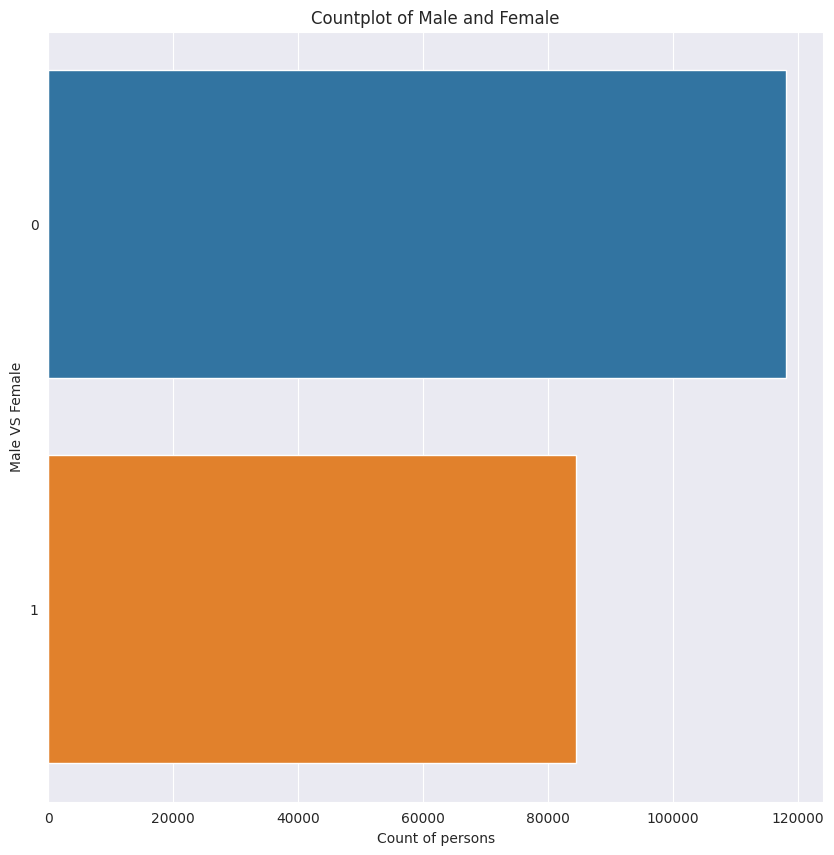

In [74]:
# Countplot of Male and Female

plt.figure(figsize = (10, 10))
sns.countplot(y = 'Male', data =attributes_df)
plt.title('Countplot of Male and Female')
plt.xlabel('Count of persons')
plt.ylabel('Male VS Female')

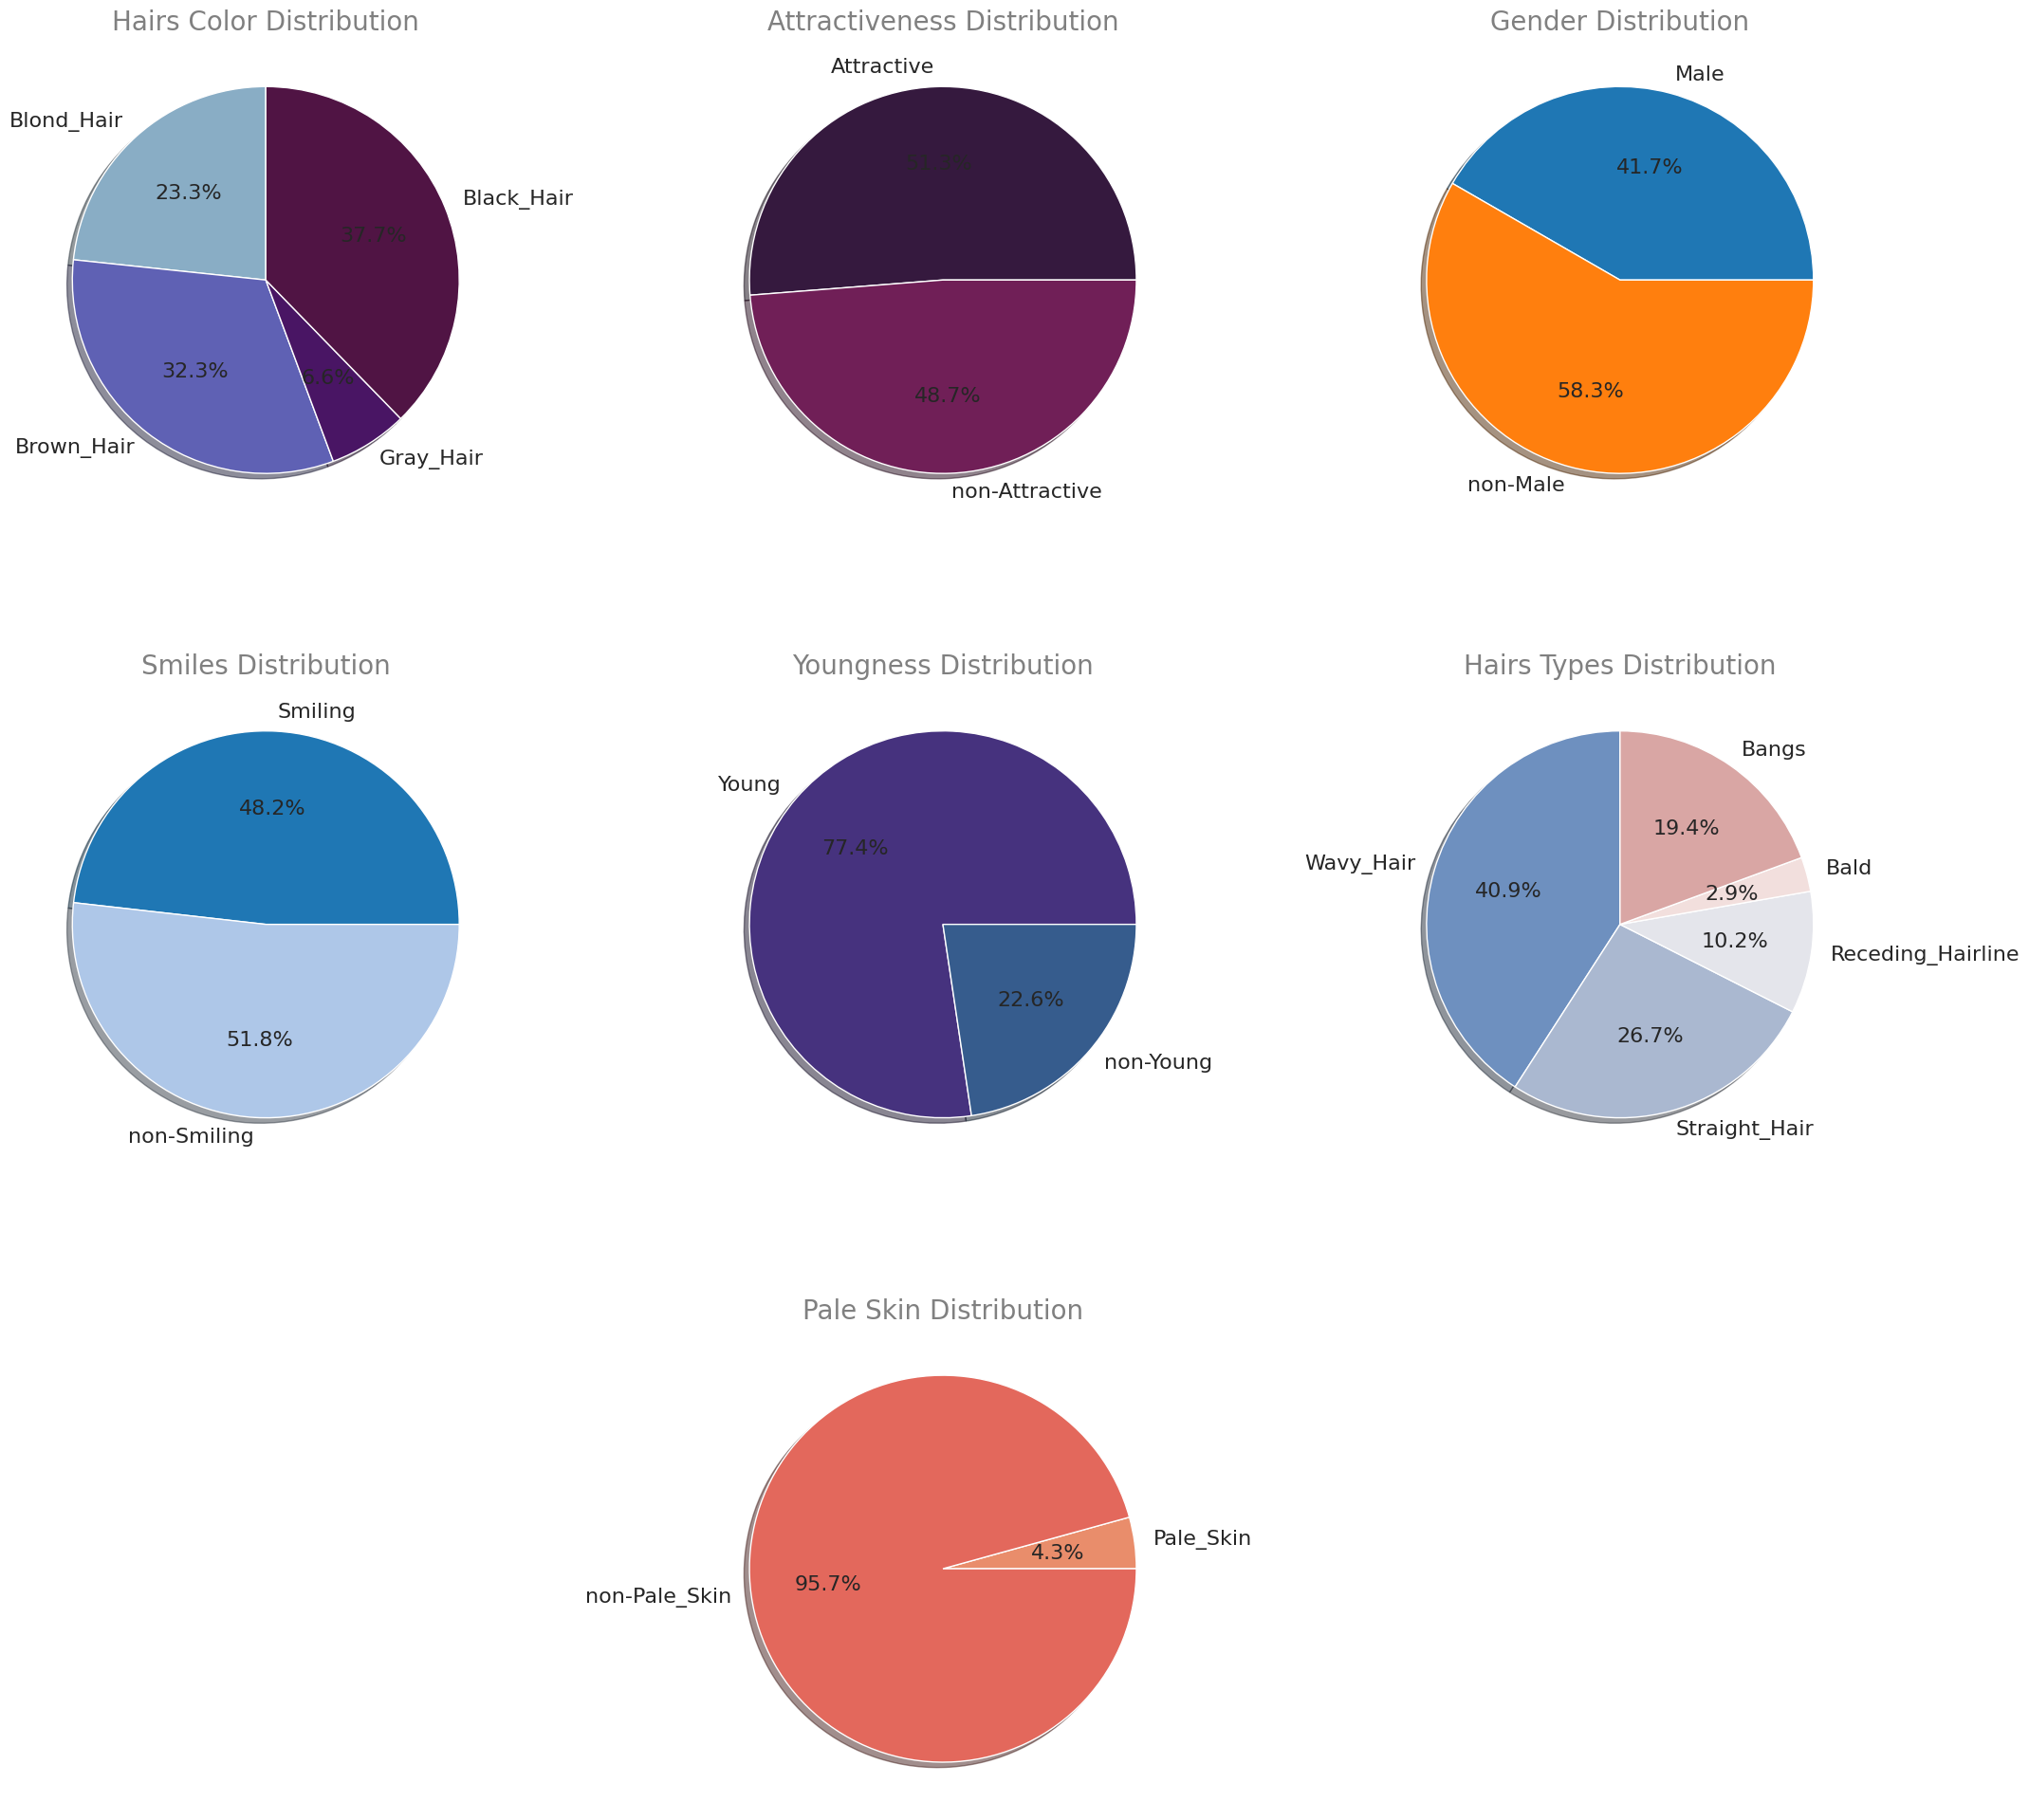

In [75]:
# show attributes distribution in pie charts

def show_pies(df = attributes_df):
        
    
    def show_categorical_dist(labels, 
                              coords,
                              title = None, 
                              colormap = 'rocket', 
                              title_params = dict(
                                  fontsize = 20, 
                                  fontweight = 20, 
                                  color = 'gray'),
                              textprops = dict(fontsize = 16)
                             ):
        
        nums = [df[label].sum() for label in labels]
        colors = sns.color_palette(colormap) 
        
        plt.subplot(*coords)
        plt.title(title, fontdict = title_params)
        plt.pie(
            nums, 
            labels=labels, 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90, 
            textprops=textprops,
            colors = colors
        )

        
    def show_binary_dist(label, 
                          coords,
                          title = None, 
                          colormap = 'rocket', 
                          title_params = dict(
                              fontsize = 20, 
                              fontweight = 20, 
                              color = 'gray'),
                          textprops = dict(fontsize = 16)
                         ):
        
        positive = df[label].sum()
        negative = len(df) - positive
        labels = [label, f'non-{label}']
        nums = [positive, negative]
        colors = sns.color_palette(colormap)
        
        plt.subplot(*coords)
        plt.title(title, fontdict = title_params)
        plt.pie(
            nums, 
            labels=labels, 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=0, 
            textprops=textprops,
            colors = colors
        )
        
    plt.figure(figsize = (25, 25))
    plt.subplots_adjust(  
        wspace = 0.4,   
        hspace = 0.2,
    )
    show_categorical_dist(
        coords = (3, 3, 1),
        labels = ['Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Black_Hair'], 
        title = 'Hairs Color Distribution',
        colormap = 'twilight'
    )
    
    show_binary_dist(
        coords = (3, 3, 2),
        label = 'Attractive', 
        title = 'Attractiveness Distribution',
        colormap = 'rocket'
    )
    
    show_binary_dist(
        coords = (3, 3, 3),
        label = 'Male', 
        title = 'Gender Distribution',
        colormap = 'tab10'
    )
    
    show_binary_dist(
        coords = (3, 3, 4),
        label = 'Smiling', 
        title = 'Smiles Distribution',
        colormap = 'tab20'
    )
    
    show_binary_dist(
        coords = (3, 3, 5),
        label = 'Young', 
        title = 'Youngness Distribution',
        colormap = 'viridis'
    )
    
    show_categorical_dist(
        coords = (3, 3, 6),
        labels = ['Wavy_Hair', 'Straight_Hair', 'Receding_Hairline', 'Bald', 'Bangs'], 
        title = 'Hairs Types Distribution',
        colormap = 'vlag'
    )
    
    show_binary_dist(
        coords = (3, 3, 8),
        label = 'Pale_Skin', 
        title = 'Pale Skin Distribution',
        colormap = 'flare'
    )
    
    plt.show()
show_pies()

## BBoxes

In [76]:
bboxes_df

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166
...,...,...,...,...,...
202594,202595.jpg,1381,91,221,306
202595,202596.jpg,137,129,114,158
202596,202597.jpg,53,76,91,126
202597,202598.jpg,195,28,91,126


In [77]:
# Summarize data

# Record counts
print("Record count: ", len(bboxes_df))

Record count:  202599


In [78]:
# Missing values

print("Missing values: \n", bboxes_df.isnull().sum())

Missing values: 
 image_id    0
x_1         0
y_1         0
width       0
height      0
dtype: int64


In [79]:
# Schema
print("Schema: \n", bboxes_df.dtypes)

Schema: 
 image_id    object
x_1          int64
y_1          int64
width        int64
height       int64
dtype: object


In [80]:
bboxes_df.describe()

,x_1,y_1,width,height
count,202599.000000,202599.000000,202599.000000,202599.000000
mean,156.764564,84.335505,194.754061,268.922329
std,164.518135,76.067284,141.770066,195.664936
min,1.000000,0.000000,0.000000,0.000000
25%,69.000000,44.000000,120.000000,166.000000
50%,110.000000,68.000000,164.000000,227.000000
75%,181.000000,98.000000,221.000000,306.000000
max,3840.000000,1858.000000,3827.000000,5299.000000


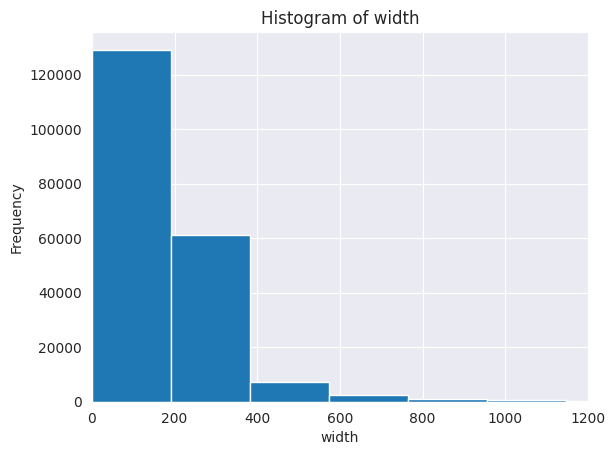

In [81]:
# Plot a histogram of the 'width' column
plt.hist(bboxes_df['width'], bins=20)
plt.title('Histogram of width')
plt.xlabel('width')
plt.ylabel('Frequency')
plt.xlim(0, 1200)
plt.show()

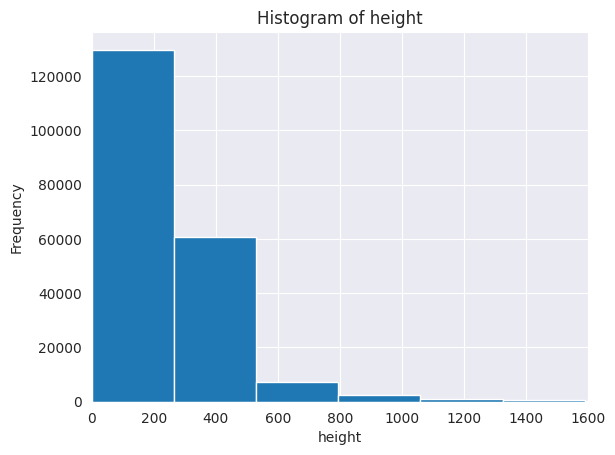

In [82]:
# Plot a histogram of the 'height' column
plt.hist(bboxes_df['height'], bins=20)
plt.title('Histogram of height')
plt.xlabel('height')
plt.ylabel('Frequency')
plt.xlim(0, 1600)
plt.show()

## Landmarks

In [83]:
landmarks_df

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150
...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,69,111,108,111,89,140,73,151,104,153
202595,202596.jpg,67,112,110,112,85,141,66,150,110,150
202596,202597.jpg,69,111,107,111,92,137,68,151,109,153
202597,202598.jpg,69,111,108,111,90,137,71,153,106,151


In [84]:
landmarks_df.columns

Index(['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
       'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x',
       'rightmouth_y'],
      dtype='object')

In [85]:
# Get record counts, missing values, and schema
record_count = len(landmarks_df)
missing_count = landmarks_df.isna().sum().sum()
schema = landmarks_df.dtypes.to_dict()

# Print results
print(f"Record count: {record_count}")
print(f"Missing value count: {missing_count}")
print("Schema:")
for col_name, dtype in schema.items():
    print(f"\t{col_name}: {dtype}")

Record count: 202599
Missing value count: 0
Schema:
	image_id: object
	lefteye_x: int64
	lefteye_y: int64
	righteye_x: int64
	righteye_y: int64
	nose_x: int64
	nose_y: int64
	leftmouth_x: int64
	leftmouth_y: int64
	rightmouth_x: int64
	rightmouth_y: int64


In [86]:
landmarks_df.describe() 

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,69.353867,111.197982,107.644031,111.161600,88.063140,135.102024,71.247459,152.113011,105.586429,152.194660
std,1.717952,1.129284,1.690252,1.169229,6.647733,4.245078,3.168011,1.799343,3.233125,1.752368
min,56.000000,98.000000,90.000000,95.000000,57.000000,93.000000,57.000000,116.000000,82.000000,114.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,73.000000,153.000000,108.000000,153.000000
max,88.000000,129.000000,124.000000,122.000000,121.000000,156.000000,90.000000,174.000000,120.000000,173.000000


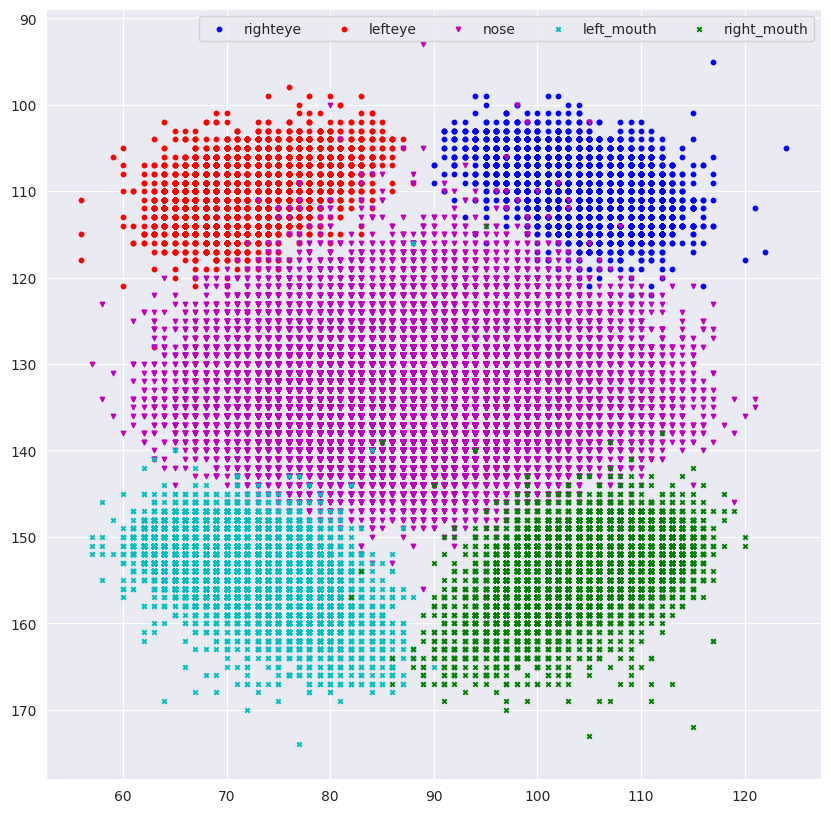

In [87]:
# plot for distribution of landmarks

def show_landmarks_distribution(df = landmarks_df):
    
    sns.set_style("darkgrid")
    plt.figure(figsize = (10, 10))
    plt.gca().invert_yaxis()
    
    plt.scatter(
        x = df.righteye_x.tolist(), 
        y = df.righteye_y.tolist(), 
        s=10, 
        c='b', 
        marker="o", 
        label='righteye'
    )
    
    plt.scatter(
        x = df.lefteye_x.tolist(), 
        y = df.lefteye_y.tolist(), 
        s=10, 
        c='r', 
        marker="o", 
        label='lefteye'
    )
    
    plt.scatter(
        x = df.nose_x.tolist(), 
        y = df.nose_y.tolist(), 
        s=10, 
        c='m', 
        marker="v", 
        label='nose'
    )
    
    plt.scatter(
        x = df.leftmouth_x.tolist(), 
        y = df.leftmouth_y.tolist(), 
        s=10, 
        c='c', 
        marker="x", 
        label='left_mouth'
    )
    plt.scatter(
        x = df.rightmouth_x.tolist(), 
        y = df.rightmouth_y.tolist(), 
        s=10, 
        c='g', 
        marker="x", 
        label='right_mouth'
    )
    
    plt.legend(loc='best', ncol = 5);
    plt.show()
    
    
show_landmarks_distribution()

## Eval

In [88]:
eval_df

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [89]:
# Get record counts, missing values, and schema
record_count = len(eval_df)
missing_count = eval_df.isna().sum().sum()
schema = eval_df.dtypes.to_dict()

# Print results
print(f"Record count: {record_count}")
print(f"Missing value count: {missing_count}")
print("Schema:")
for col_name, dtype in schema.items():
    print(f"\t{col_name}: {dtype}")


Record count: 202599
Missing value count: 0
Schema:
	image_id: object
	partition: int64


In [90]:
# see value counts
eval_df['partition'].value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

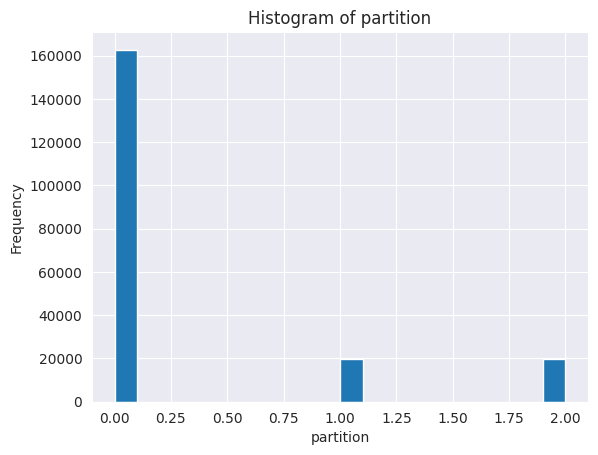

In [91]:
# Plot a histogram of the 'x1' column
plt.hist(eval_df['partition'], bins=20)
plt.title('Histogram of partition')
plt.xlabel('partition')
plt.ylabel('Frequency')
plt.show()

## Image

### See example Images and their attributes

In [92]:
main_folder = "img_align_celeba/"
images_folder = main_folder + 'img_align_celeba/'

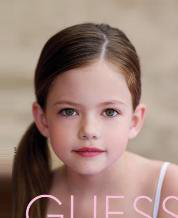

In [93]:
# plot image
#IMAGE_SHAPE = (224, 224)
image_example1 = images_folder + '020007.jpg'
#image_example = Image.open(image_example).resize(IMAGE_SHAPE)
see_example1 = Image.open(image_example1)
see_example1

In [94]:
attributes_df.loc[image_example1.split('/')[-1]][['Smiling','Male','Young']]

Smiling    0
Male       0
Young      1
Name: 020007.jpg, dtype: int64

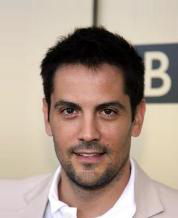

In [95]:
image_example2 = images_folder + '028809.jpg'
see_example2 = Image.open(image_example2)
see_example2

In [96]:
attributes_df.loc[image_example2.split('/')[-1]][['Smiling','Male','Young']]

Smiling    1
Male       1
Young      0
Name: 028809.jpg, dtype: int64

In [97]:
IMG_PATH = os.path.join('img_align_celeba/img_align_celeba')
FEATURE_PATH = os.path.join('list_attr_celeba.csv')

In [98]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(10)

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
5,176200.jpg,Female
6,041602.jpg,Female
7,065466.jpg,Male
8,019028.jpg,Male
9,164498.jpg,Female


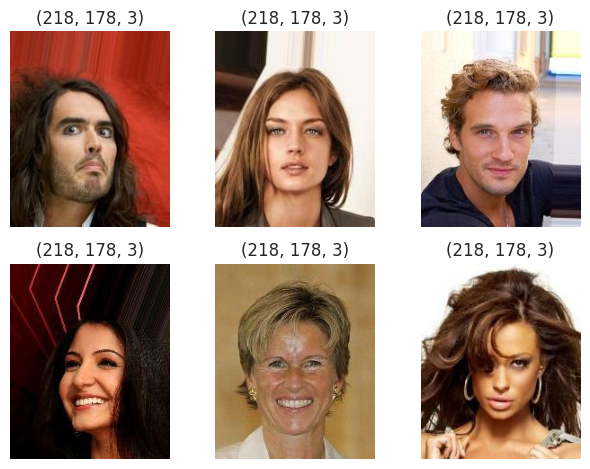

In [99]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [100]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Female    1442
Male      1058
Name: Gender, dtype: int64


In [101]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")


<Axes: >

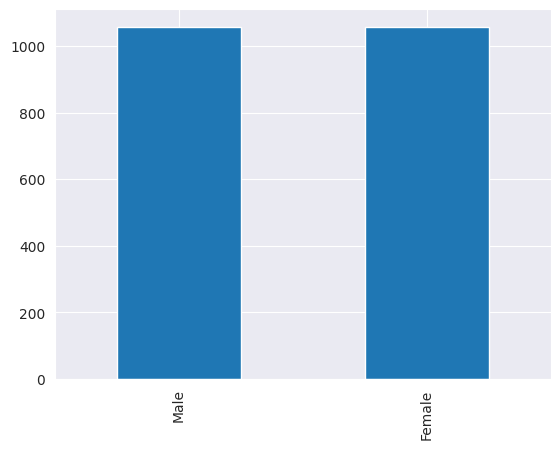

In [102]:
df["Gender"].value_counts().plot.bar()

In [103]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [104]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1481
Total Test Sample Images :  425
Total Validation Sample Images :  210


In [105]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 15

In [106]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1481 validated image filenames belonging to 2 classes.


In [107]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 210 validated image filenames belonging to 2 classes.


In [108]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    IMG_PATH + "/",  
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 425 validated image filenames.


In [109]:
base_resnet_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape= IMAGE_SIZE + (3,))

In [110]:
base_resnet_model.trainable = False
base_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 224, 184, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 109, 89, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 109, 89, 64)  256         ['conv1_conv[0][0]']      

In [111]:
resnet_model = Sequential(
    [
    base_resnet_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
]
)

In [112]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 6, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 86016)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               22020352  
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [113]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [114]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)
callbacks = [earlystop, learning_rate_reduction]

In [115]:
history = resnet_model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 0.9582 - accuracy: 0.4918

98/98 [==============================] - 23s 182ms/step - loss: 0.9582 - accuracy: 0.4918 - val_loss: 0.6973 - val_accuracy: 0.5095 - lr: 0.0010
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.5396

98/98 [==============================] - 19s 197ms/step - loss: 0.7300 - accuracy: 0.5396 - val_loss: 0.6787 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.5784

98/98 [==============================] - 17s 174ms/step - loss: 0.7100 - accuracy: 0.5784 - val_loss: 0.6662 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5655

98/98 [==============================] - 17s 173ms/step - loss: 0.6915 - accuracy: 0.5655 - val_loss: 0.7460 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 5/10
98/98 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.5559

98/98 [==============================] - 17s 171ms/step - loss: 0.7087 - accuracy: 0.5559 - val_loss: 0.7514 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 6/10
98/98 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.5389

98/98 [==============================] - 17s 172ms/step - loss: 0.6995 - accuracy: 0.5389 - val_loss: 0.6745 - val_accuracy: 0.5381 - lr: 0.0010
Epoch 7/10
98/98 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5293

98/98 [==============================] - 17s 173ms/step - loss: 0.6955 - accuracy: 0.5293 - val_loss: 0.6933 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 8/10
98/98 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5239

98/98 [==============================] - 17s 173ms/step - loss: 0.6925 - accuracy: 0.5239 - val_loss: 0.6931 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 9/10
98/98 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5437

98/98 [==============================] - 17s 178ms/step - loss: 0.6880 - accuracy: 0.5437 - val_loss: 0.6986 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 10/10
98/98 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.5532

98/98 [==============================] - 18s 179ms/step - loss: 0.6865 - accuracy: 0.5532 - val_loss: 0.6772 - val_accuracy: 0.6476 - lr: 0.0010


In [116]:
resnet_model.save("celeb_vgg_model.h5")

In [117]:
resnet_model.evaluate(test_generator)

29/29 [==============================] - 2s 37ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [118]:
predict = resnet_model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

29/29 [==============================] - 2s 45ms/step


In [119]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [120]:
test_df

,image_id,Gender,Prediction
4,073193.jpg,Female,Female
1997,071990.jpg,Male,Female
1213,183728.jpg,Female,Female
1180,023502.jpg,Male,Female
592,093896.jpg,Female,Female
...,...,...,...
33,191989.jpg,Female,Female
823,147495.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Male


In [121]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[136,  70],
       [ 91, 128]])

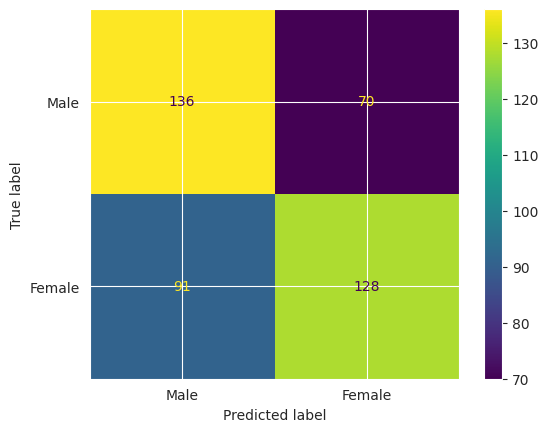

In [122]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()